# MODS205
# Digital Finance

# project : Part 2

## Servane Desvignes et El arji Hamza

## Imports

In [1]:
import requests
import xlsxwriter 
import math 
import numpy as np
import random
import datetime
import mplfinance as mpf
import yfinance as yf # permet de récuperer l'historique des cours boursier
import pandas as pd # gestion de data frame 
from datetime import datetime, timedelta
from ta.trend import IchimokuIndicator # Ta-lib (Technical Analysis Library) calcule la plupart des indicateurs techniques
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px

## PART 4


## __First idea__



## 4. Run an automated trading algorithm using any method you want (moving averages, candlesticks, patterns, ML, …) over the sample period. You can only have 3 positions: buy/sell, short/cover, do nothing. You cannot use derivative products. Can you beat the market?

[*********************100%%**********************]  1 of 1 completed
c:\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


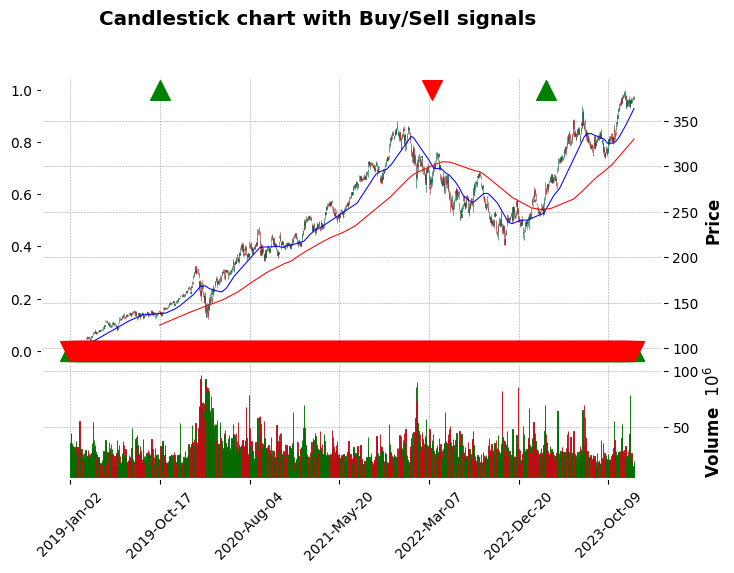

In [2]:
# Step 1: Get Historical Stock Data
def get_historical_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Step 2: Calculate Moving Averages
def calculate_moving_averages(stock_data, short_window, long_window):
    stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
    stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()
    return stock_data

# Step 3: Define Buy/Sell Signals
def generate_signals(stock_data, short_window, long_window):
    signals = pd.DataFrame(index=stock_data.index)  # Create a DataFrame for signals
    signals['Signal'] = 0 # Initialize the Signal column to 0
    signals['Signal'] = np.where(stock_data['Short_MA'] > stock_data['Long_MA'], 1, 0) # Set signal to 1 when the short MA is above the long MA
    signals['Position'] = signals['Signal'].diff() # Take the difference of the signals to generate actual trading orders, if we go from 0 to 1, buy, if go from 1 to 0, sell
    return signals

# Step 4: Implement Trading Logic
def execute_trades(stock_data, signals):
    transactions = []
    for index, signal in signals.iterrows():
        if signal['Position'] == 1:
            transactions.append(1)  # Buy
        elif signal['Position'] == -1:
            transactions.append(-1)  # Sell
        else:
            transactions.append(0)  # Do nothing
    positions = pd.DataFrame(data=transactions, index=signals.index, columns=['Stock'])
    return positions

# Step 5: Evaluate Performance and Plot Candlestick with Signals
def evaluate_performance_and_plot(stock_data, positions):
    
    # Calculate returns based on positions.
    ##pct_change() calculates the percentage change between the current and a prior element, 
    # for instance if the close price is 100 and the prior close price is 95, the percentage change is (100-95)/95 = 5.26%. 
    # Then we multiply the percentage change by the position to get the returns.
    stock_data['Returns'] = stock_data['Close'].pct_change() * positions['Stock'].shift(1) 
    
    # Calculate cumulative returns
    # we add 1 because we want to have a grow factor. cumprod() gives the cumulative returns over time.
    stock_data['Cumulative_Returns'] = (1 + stock_data['Returns']).cumprod() 

    # Plotting
    apds = [mpf.make_addplot(stock_data['Short_MA'], color='blue', width=0.75), # Short moving average
            mpf.make_addplot(stock_data['Long_MA'], color='red', width=0.75), # Long moving average
            mpf.make_addplot((positions['Stock'] > 0).astype(int), type='scatter', markersize=200, marker='^', color='green'), # Buy signals
            mpf.make_addplot((positions['Stock'] < 0).astype(int), type='scatter', markersize=200, marker='v', color='red')] # Sell signals

    mpf.plot(stock_data, type='candle', addplot=apds, volume=True, figratio=(12,8), style='charles',
             title=f"Candlestick chart with Buy/Sell signals", ylabel='Price')

# Main function
def main():
    # Define parameters
    symbol = 'MSFT'
    start_date = '2019-01-01'
    end_date = '2024-01-01'
    short_window = 50
    long_window = 200

    # Execute steps
    stock_data = get_historical_data(symbol, start_date, end_date)
    stock_data = calculate_moving_averages(stock_data, short_window, long_window)
    signals = generate_signals(stock_data, short_window, long_window)
    positions = execute_trades(stock_data, signals)
    evaluate_performance_and_plot(stock_data, positions)

if __name__ == "__main__":
    main()


## __Second idea : Stratégie 1 : Ichimoku Cloud__



### __Calcul des indicateurs__

On note $P_t$ le prix de clôture à la date $t$. Formules pour les calculs des indicateurs :

- **Tenkan Sen** : The Tenkan Sen line is calculated as the average of the highest and lowest prices over the last 9 periods.  It is designed to identify short-term support and resistance levels.  The formula is :
  $$\text{(Tenkan Sen)}_t = \frac{\text{High}_{t-9:t} + \text{Low}_{t-9:t}}{2}$$

- **Kijun Sen** : The Kijun Sen line represents the average of the highest and lowest prices over the last 26 periods. It is intended to show a longer-term price trend in relation to the Tenkan Sen.  The formula is :
  $$\text{(Kijun Sen)}_t = \frac{\text{High}_{t-26:t} + \text{Low}_{t-26:t}}{2}$$

- **Ichimoku A (Senkou Span A)** : Ichimoku A is the average of Tenkan Sen and Kijun Sen, used to form one of the boundaries of the Ichimoku cloud (kumo). This is used to determine the future trend. The formula is :
  $$\text{(Ichimoku A)}_t = \frac{\text{(Tenkan Sen)}_t + \text{(Kijun Sen)}_t}{2}$$

- **Ichimoku B (Senkou Span B)** : This line is the average of the highest and lowest prices over the last 52 periods, forming the second frontier of the Ichimoku cloud, which is used to generate the second frontier of the cloud, providing an indication of the strength of the trend over an even longer period. The formula is :
  $$\text{(Ichimoku B)}_t = \frac{\text{High}_{t-52:t} + \text{Low}_{t-52:t}}{2}$$

- **Ichimoku Max** : This is the maximum between Ichimoku A and Ichimoku B. This value can be used to identify extremes in the evolution of the "cloud" and thus provide additional indications of potential turning points in the market. The formula is :
  $$\text{(Ichimoku Max)}_t = \max(\text{Ichimoku A}_{t}, \text{Ichimoku B}_{t})$$

- **Ichimoku Min** : This is the minimum between Ichimoku A and Ichimoku B. This value can be used to identify extremes in the evolution of the "cloud" and thus provide additional indications of potential turning points in the market. The formula is :
  $$\text{(Ichimoku Min)}_t = \min(\text{Ichimoku A}_{t}, \text{Ichimoku B}_{t})$$


In [3]:
# precize the currency
symbol = "ATOM-EUR" 

# Ending date
end_date = datetime.now()

# study duration (T days)
T = 50
start_date = end_date - timedelta(days=T)

# Get the data
data = yf.download(symbol, start=start_date, end=end_date, interval="2m")
try:
    data.index = data.index.tz_convert(None)
except:
    print("Impossible to convert the timezone of the index")
    
# create the Ichimoku indicator
ichimoku = IchimokuIndicator(high=data["High"], low=data["Low"])

# Add the ichimoku indicator to the data
data["Ichimoku_A"] = ichimoku.ichimoku_a()
data["Ichimoku_B"] = ichimoku.ichimoku_b()

# Add the min and max of the ichimoku indicator
data["Ichimoku_Min"] = data[["Ichimoku_A", "Ichimoku_B"]].min(axis=1)
data["Ichimoku_Max"] = data[["Ichimoku_A", "Ichimoku_B"]].max(axis=1)

[*********************100%%**********************]  1 of 1 completed


### __Plot the indicators__

In [4]:
# Plot with Plotly

# The candlestick plot
fig = go.Figure(
    data=[
        go.Candlestick(
            x=data.index,
            open=data["Open"],
            high=data["High"],
            low=data["Low"],
            close=data["Close"],
        )
    ]
)

# Add the ichimoku_A indicator
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data["Ichimoku_A"],
        line=dict(color="blue", width=1),
        name="Ichimoku A",
    )
)

# Add the ichimoku_B indicator
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data["Ichimoku_B"],
        line=dict(color="red", width=1),
        name="Ichimoku B",
    )
)

last_10_closes = data['Close'].tail(400)

max_close = last_10_closes.max()
min_close = last_10_closes.min()
fig.update_xaxes(rangebreaks=[dict(values=data.index[:-1000])])
fig.update_yaxes(range=[min_close, max_close])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


### __Strategy__

We write $P_t$ as  the closing price at $t$. The strategy is :

- Si $P_{t-1} < \text{(Ichimoku Max)}_{t-1}$ et $P_t > \text{(Ichimoku Max)}_t$, then we buy.
- Si $P_{t-1} > \text{(Ichimoku Min)}_{t-1}$ et $P_t < \text{(Ichimoku Min)}_t$, then we sell.
- Si $P_t < \text{(Ichimoku Max)}_t$ et $P_t > \text{(Ichimoku Min)}_t$, we do nothing.

We compare ou strategy with a passig investment ( Buy and Hold).

In [5]:
# Starting amount of money
S = 100
FEES = 0 # we do not take into account the fees
portfolio_values = []
portfolio_values_buy_and_hold = [S]
nb_transaction = 0
sell = False
buy = False
signals = []

for index, row in data[:-1].iterrows():

    row_next = data.shift(-1).loc[index]
    row_precedent = data.shift(1).loc[index]

    P_t = row["Close"] #price of the stock at time t
    P_t_1 = row_next["Close"] # price of the stock at time t+1
    P_t_moins_1 = row_precedent["Close"] # price of the stock at time t-1
    
    #-----------------------BUY-----------------------------------
    # We buy when we pass below the Ichimoku cloud

    if (
        row_precedent["Ichimoku_Max"] >= P_t_moins_1
        and row["Ichimoku_Max"] < P_t
    ):
        buy = True
        nb_transaction += 1
        S -= FEES * S # frais de transaction
    
    
    
    #-----------------------SELL-----------------------------------
    # We sell when we pass above the Ichimoku cloud
    if (
        row_precedent["Ichimoku_Min"] <= P_t_moins_1
        and row["Ichimoku_Min"] > P_t
    ):
        sell = True
        nb_transaction += 1
        S -= FEES * S # frais de transaction
    
    
    #-----------------------CANCEL---------------------------------
    if buy and row["Ichimoku_Max"] > P_t:
        S -= FEES * S
        buy = False

    if sell and row["Ichimoku_Min"] < P_t:
        S -= FEES * S
        sell = False
    
    
    #-----------------------UPDATE---------------------------------
    if sell:
        S -= (P_t_1 - P_t) / P_t * S # S_{t+1} = S_t - (P_{t+1} - P_t) / P_t * S_t
    if buy:
        S += (P_t_1 - P_t) / P_t * S # S_{t+1} = S_t + (P_{t+1} - P_t) / P_t * S_t
    portfolio_values_buy_and_hold.append(portfolio_values_buy_and_hold[-1] + (P_t_1 - P_t) / P_t * portfolio_values_buy_and_hold[-1])
    
    
    #--------------------------------------------------------------
    print(f"Date: {index}, Buy: {buy}, Sell: {sell}, S: {S:.2f} €\r", end="")

    portfolio_values.append(S)
    signals.append(1 if buy else -1 if sell else 0)

signals.append(0)
print("\n")
print(f"Nombre de transaction effectué: {nb_transaction}")
print("Valorisation du portefeuille: {:.2f}€".format(S))

# Plot portfolio values using plotly
#------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=portfolio_values, mode="lines", name="Ichimoku Strategy"))
fig.update_layout(title="Portfolio values", xaxis_title="Date", yaxis_title="Value")
fig.add_trace(go.Scatter(x=data.index, y=portfolio_values_buy_and_hold, mode="lines", name="Buy and Hold"))
fig.show()
#------------------------------------

Date: 2024-03-11 08:38:00, Buy: True, Sell: False, S: 721.22 €€

Nombre de transaction effectué: 1469
Valorisation du portefeuille: 721.22€



$\textbf{ ------------------------------------------------------------THE END-----------------------------------------------------------------------------}$
